# Neural Style Transfer

Neural Style Trasnfer is a deep learning model able to perform *style transfer*, that is to say, apply the style of an image to another image. Unlike a CycleGan, this model does not need datasets of images to transform and style images. Instead a Neural Style Transfer model uses a more complex loss function which is the weighted sum of three distinct parts:
- Content loss: This part of the loss makes sure that the content of the image does not change when applying a new style.
- Style loss: This loss forces the network to apply the style to the base image.
- Total variance loss: This part of the loss ensures the resulting image is not pixelated.

The training consists of minimazing the loss function using gradient desccent (ie: by updating each pixel value over iterations).

It is really easy to create an CycleGAN using Tensorflow as show in this [Tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer).

Let's build a Neural Style Transfer model "from scratch" to have a better understanding!

## Hand Made Neural Style Transfer

In [1]:
import os
import time
import numpy as np
import pandas as pd
import pickle

import PIL.Image
import IPython.display as display

import tensorflow as tf
import keras.backend as K

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

2023-12-05 16:51:11.282278: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 16:51:11.287698: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 16:51:11.358926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 16:51:11.358979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 16:51:11.360725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [3]:
def load_img(img_path):
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    plt.axis("off")
    if title:
        plt.title(title)

### Load and Visualize Data

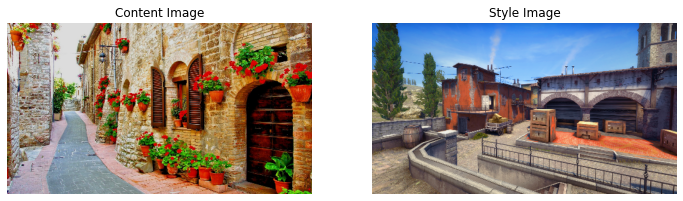

In [5]:
content_image = load_img("italy.jpg")
style_image = load_img("inferno.png")

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### Expected Result

In [6]:
# import tensorflow_hub as hub

# hub_model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2")
# stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
# # stylized_image = hub_model(tf.constant(style_image), tf.constant(content_image))[0]
# stylized_image = tensor_to_image(stylized_image)
# plt.imshow(stylized_image)
# plt.axis("off")

### Test VGG19

In [7]:
# x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
# x = tf.image.resize(x, (224, 224))
# vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
# prediction_probabilities = vgg(x)
# prediction_probabilities.shape

In [8]:
# predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
# [(class_name, prob) for (number, class_name, prob) in predicted_top_5]

### Select Layers from VGG19

In [9]:
# vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# print()
# for layer in vgg.layers:
#   print(layer.name)

In [10]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Neural Style Transfer Model

In [11]:
def vgg_layers(layer_names):
    """ Creates a VGG model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on ImageNet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [12]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [13]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


In [14]:
class NeuralStyleTransfer():

    def __init__(self, content_img, style_img, content_weight=1e4, style_weight=1e-2, variance_weigth=30):
        self.content_img = self.load_img(content_img)
        self.style_img = self.load_img(style_img)
        self.combined_img = None
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.variance_weigth = variance_weigth

        self.content_layers = ['block5_conv2'] 

        self.style_layers = ['block1_conv1',
                             'block2_conv1',
                             'block3_conv1', 
                             'block4_conv1', 
                             'block5_conv1']

        self.nb_content_layers = len(content_layers)
        self.nb_style_layers = len(style_layers)

        # Build Model
        self.style_extractor = vgg_layers(style_layers)
        self.style_outputs = self.style_extractor(self.style_img * 255)

        self.extractor = StyleContentModel(style_layers, content_layers)

        self.results = self.extractor(tf.constant(self.content_img))

        print('Styles:')
        for name, output in sorted(self.results['style'].items()):
            print("  ", name)
            print("    shape: ", output.numpy().shape)
            print("    min: ", output.numpy().min())
            print("    max: ", output.numpy().max())
            print("    mean: ", output.numpy().mean())
            print()

        print("Contents:")
        for name, output in sorted(self.results['content'].items()):
            print("  ", name)
            print("    shape: ", output.numpy().shape)
            print("    min: ", output.numpy().min())
            print("    max: ", output.numpy().max())
            print("    mean: ", output.numpy().mean())

        self.style_targets = self.extractor(self.style_img)['style']
        self.content_targets = self.extractor(self.content_img)['content']

        self.image = tf.Variable(self.content_img)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


    def load_img(self, img_path):
        max_dim = 512
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)

        shape = tf.cast(tf.shape(img)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim

        new_shape = tf.cast(shape * scale, tf.int32)

        img = tf.image.resize(img, new_shape)
        img = img[tf.newaxis, :]
        return img
    
    def show_image(self):
        img = tensor_to_image(self.image)
        plt.imshow(img)
        plt.axis("off")
            
    def clip_0_1(self, img):
        return tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)
    
    def high_pass_x_y(self):
        x_var = self.image[:, :, 1:, :] - self.image[:, :, :-1, :]
        y_var = self.image[:, 1:, :, :] - self.image[:, :-1, :, :]
        return x_var, y_var

    def content_loss(self, outputs):
        content_outputs = outputs['content']
        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-self.content_targets[name])**2) 
                                 for name in content_outputs.keys()])
        content_loss *= self.content_weight / num_content_layers
        return content_loss

    def style_loss(self, outputs):
        style_outputs = outputs['style']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-self.style_targets[name])**2) 
                               for name in style_outputs.keys()])
        style_loss *= self.style_weight / num_style_layers
        return style_loss

    def variance_loss(self):
        x_deltas, y_deltas = self.high_pass_x_y()
        variance_loss = tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas)) # Or use: tf.image.total_variation(image)
        variance_loss *= self.variance_weigth
        return variance_loss
    
    def loss(self, outputs):
        content_loss = self.content_loss(outputs)
        style_loss = self.style_loss(outputs)
        variance_loss = self.variance_loss()

        loss = content_loss + style_loss + variance_loss
        return loss
    
    @tf.function()
    def train_step(self):
        with tf.GradientTape() as tape:
            outputs = self.extractor(self.image)
            loss = self.loss(outputs)

        grad = tape.gradient(loss, self.image)
        self.optimizer.apply_gradients([(grad, self.image)])
        self.image.assign(self.clip_0_1(self.image))

    def fit(self, epochs, steps_per_epoch):
        start = time.time()

        epoch = 0
        for n in range(epochs):
            epoch += 1
            step = 0
            for m in range(steps_per_epoch):
                step += 1
                self.train_step()
                print(".", end='', flush=True)
            display.clear_output(wait=True)
            display.display(tensor_to_image(self.image))
            print(f"Epoch {epoch} | Train step: {step}")

        end = time.time()
        print("Total time: {:.1f}".format(end-start))


In [15]:
nst = NeuralStyleTransfer(content_img="italy.jpg",
                          style_img="inferno.png")

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.23992284
    max:  17154.586
    mean:  856.5643

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  348709.88
    mean:  30807.367

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  1903049.4
    mean:  37572.78

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  21027752.0
    mean:  535426.6

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  246261.42
    mean:  4211.017

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  1643.7925
    mean:  26.186058


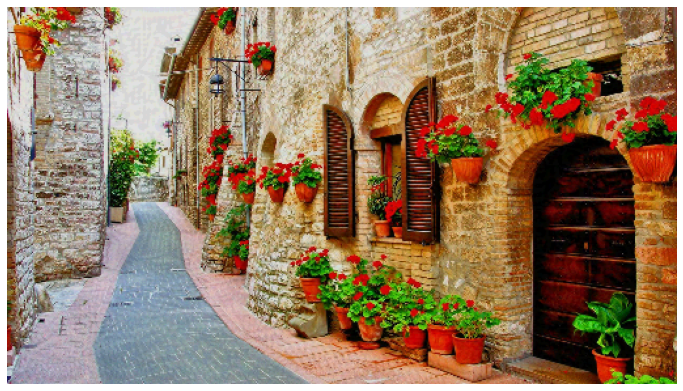

In [16]:
TRAINING_STEPS = 1
for _ in range(TRAINING_STEPS):
    nst.train_step()
nst.show_image()

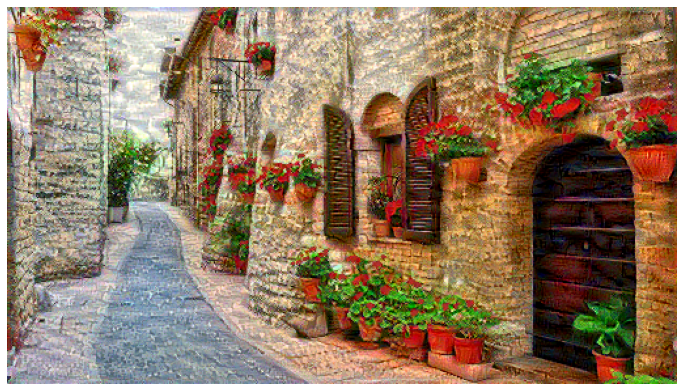

In [17]:
TRAINING_STEPS = 10
for _ in range(TRAINING_STEPS):
    nst.train_step()
nst.show_image()

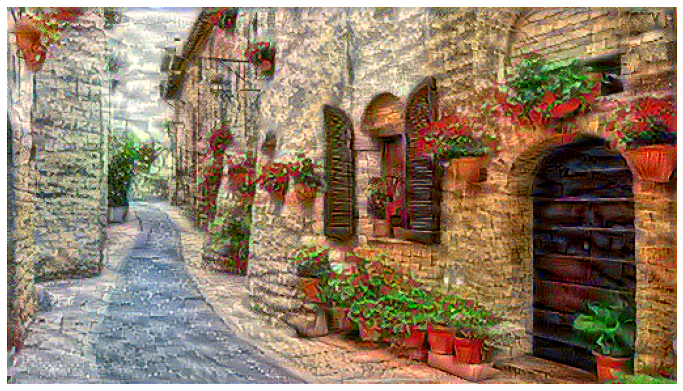

In [18]:
TRAINING_STEPS = 10
for _ in range(TRAINING_STEPS):
    nst.train_step()
nst.show_image()

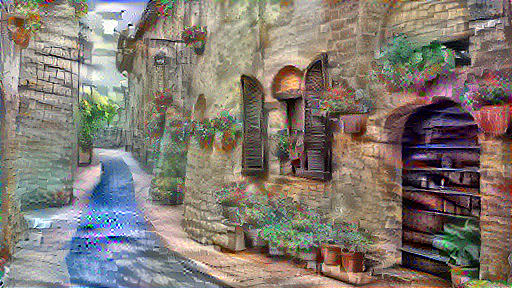

Epoch 4 | Train step: 100
Total time: 669.6


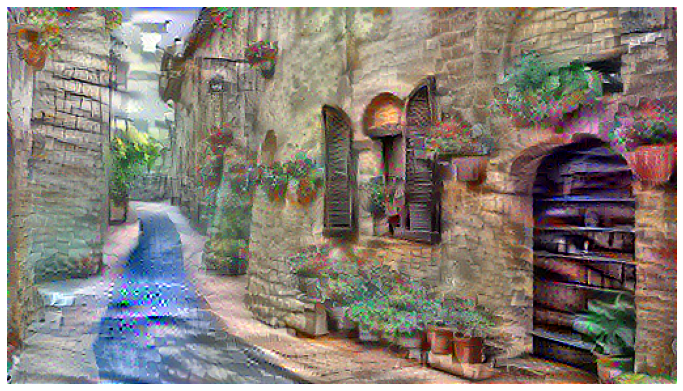

In [19]:
nst.fit(4, 100)
nst.show_image()